In [ ]:
import numpy as np
import pandas as pd
import os
import PIL
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve,roc_auc_score



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#pandas.read_csv("/content/drive/My Drive/folder_0/folder_1/file.csv")
train_df = pd.read_csv('/content/drive/Shareddrives/519 project/train_COVIDx9A.txt', sep=" ", header=None)

#Columns are added because it was seen that column names were 0,1,2,3, so new column names are added
#which are given in descriptions
train_df.columns=['patient id', 'filename', 'class', 'data source']

# Since we are doing image classification, patient id and data source is of no importance to us, so
#we cn drop them
train_df=train_df.drop(['patient id', 'data source'], axis=1 )

In [ ]:
train_df.head()

,filename,class
0,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia
1,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia
2,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia
3,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia
4,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia


In [ ]:
test_df = pd.read_csv('/content/drive/Shareddrives/519 project/test_COVIDx9A.txt', sep=" ", header=None)
test_df.columns=['id', 'filename', 'class', 'data source' ]
test_df=test_df.drop(['id', 'data source'], axis=1 )

In [ ]:
test_df.head()

,filename,class
0,MIDRC-RICORD-1C-419639-003251-46647-0.png,COVID-19
1,MIDRC-RICORD-1C-419639-001464-39871-0.png,COVID-19
2,MIDRC-RICORD-1C-419639-000918-78965-0.png,COVID-19
3,MIDRC-RICORD-1C-419639-003318-64285-0.png,COVID-19
4,MIDRC-RICORD-1C-419639-001015-81591-0.png,COVID-19


In [ ]:
train_df['class'].value_counts()

pneumonia    5555
normal       5555
COVID-19     5555
Name: class, dtype: int64

In [ ]:
covid  = train_df[train_df['class']=='COVID-19']   #negative values in class column
normal = train_df[train_df['class']=='normal']  #positive values in class column
pneumonia = train_df[train_df['class']=='pneumonia']
from sklearn.utils import resample
#majority class that  is negative, we need to downsample/decrease that class so that there is no bias
#n_samples = 2158 means we want 2158 sample of class negative, since there are 2158 samples of class positive
df_covid_downsampled = resample(covid, replace = True, n_samples = 5555) 
df_normal_downsampled = resample(normal, replace = True, n_samples = 5555)
#concatenate
train_df = pd.concat([pneumonia, df_covid_downsampled,df_normal_downsampled])

from sklearn.utils import shuffle
train_df = shuffle(train_df) # shuffling so that there is particular sequence

In [ ]:
train_df['class'].value_counts()

COVID-19     5555
pneumonia    5555
normal       5555
Name: class, dtype: int64

In [ ]:
test_df['class'].value_counts()

COVID-19     200
normal       100
pneumonia    100
Name: class, dtype: int64

In [ ]:
train_data, valid_data = train_test_split(train_df, train_size=0.8, random_state=0)

In [ ]:
train_path = '/content/drive/Shareddrives/519 project/train_30000/'  #directory path
test_path = '/content/drive/Shareddrives/519 project/test.zip (Unzipped Files)'

In [ ]:
#train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, 
                                   #shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True, vertical_flip =True)
train_datagen = ImageDataGenerator(rescale = 1./255., shear_range = 0.2)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

#Now fit the them to get the images from directory (name of the images are given in dataframe) with augmentation


train_gen = train_datagen.flow_from_dataframe(dataframe = train_data, directory=train_path, x_col='filename', 
                                              y_col='class', target_size=(300,300), batch_size=64, 
                                               classes=['COVID-19','normal','pneumonia'])
valid_gen = test_datagen.flow_from_dataframe(dataframe = valid_data, directory=train_path, x_col='filename',
                                             y_col='class', target_size=(300,300), batch_size=64, 
                                            classes=['COVID-19','normal','pneumonia'])
test_gen = test_datagen.flow_from_dataframe(dataframe = test_df, directory=test_path, x_col='filename', 
                                            y_col='class', target_size=(300,300), batch_size=32,
                                             classes=['COVID-19','normal','pneumonia'])

/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 10603 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 2729 validated image filenames belonging to 3 classes.
Found 650 validated image filenames belonging to 3 classes.
Found 400 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 2683 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [ ]:
import tensorflow as tf
#Our base model is InceptionResNetV2, new readers are encouraged to see the architecture of this particular model

base_model = tf.keras.applications.ResNet50V2(weights='imagenet', input_shape = (300,300,3),
                                                     include_top=False,classifier_activation='softmax')
for layer in base_model.layers:
    layer.trainable = False

94683136/94668760 [==============================] - 1s 0us/step


In [ ]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig, ax = plt.subplots(1,2,figsize=(20,10))
  ax[0].plot(epochRange,history.history['accuracy'],'b',label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],'r',label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch', fontsize = 20)
  ax[0].set_ylabel('Accuracy', fontsize = 20)
  ax[0].legend()
  ax[0].grid(color='gray', linestyle='--')
  ax[1].plot(epochRange,history.history['loss'],'b',label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],'r',label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch', fontsize = 20)
  ax[1].set_ylabel('Loss', fontsize = 20)
  ax[1].legend()
  ax[1].grid(color='gray', linestyle='--')
  plt.show()

In [ ]:
#Now we will add some more layers to the base model for our requirements

model = tf.keras.Sequential([
    base_model, 
    tf.keras.layers.GlobalAveragePooling2D(), 
    #tf.keras.layers.Conv2D(128, (3, 3), activation='relu', input_shape = (200,200,3)),
    ##tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid'),
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(), 
    tf.keras.layers.Dropout(0.2), 
    tf.keras.layers.Dense(3, activation='softmax')
])

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("covid_classifier_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', mode = "min", verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight = "balanced", classes = np.unique(train_gen.classes), y = train_gen.classes)
cw = dict(zip(np.unique(train_gen.classes), weights))


In [ ]:
history = model.fit(train_gen, class_weight = cw,
                    validation_data=valid_gen, epochs= 20, 
                    callbacks = callbacks)

Epoch 1/20
43/43 [==============================] - 1925s 44s/step - loss: 0.4872 - accuracy: 0.8139 - val_loss: 0.4327 - val_accuracy: 0.8108 - lr: 0.0010
Epoch 2/20
43/43 [==============================] - 101s 2s/step - loss: 0.2696 - accuracy: 0.8985 - val_loss: 0.3200 - val_accuracy: 0.8815 - lr: 0.0010
Epoch 3/20
43/43 [==============================] - 99s 2s/step - loss: 0.2131 - accuracy: 0.9296 - val_loss: 0.3244 - val_accuracy: 0.8831 - lr: 0.0010
Epoch 4/20
43/43 [==============================] - ETA: 0s - loss: 0.1684 - accuracy: 0.9403
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
43/43 [==============================] - 101s 2s/step - loss: 0.1684 - accuracy: 0.9403 - val_loss: 0.3831 - val_accuracy: 0.8462 - lr: 0.0010
Epoch 5/20
43/43 [==============================] - 101s 2s/step - loss: 0.1200 - accuracy: 0.9648 - val_loss: 0.3037 - val_accuracy: 0.8769 - lr: 5.0000e-04
Epoch 6/20
43/43 [==============================] - 102s 2s/step -

In [ ]:
#model.load_weights('./covid_classifier_model.h5')
model.evaluate(test_gen)

13/13 [==============================] - 335s 27s/step - loss: 0.6038 - accuracy: 0.7925


[0.6038158535957336, 0.7925000190734863]

In [ ]:
predictions = model.predict(test_gen)

In [ ]:
test_class=np.array([])
prediction_class = np.array([])
for i in range(13):
   i, l = test_gen[i]
   test_class = np.concatenate((test_class, np.argmax(l,axis=1)))
   prediction_class = np.concatenate((prediction_class, np.argmax(model.predict(i),axis=1)))

In [ ]:
cm = confusion_matrix(test_class,prediction_class)

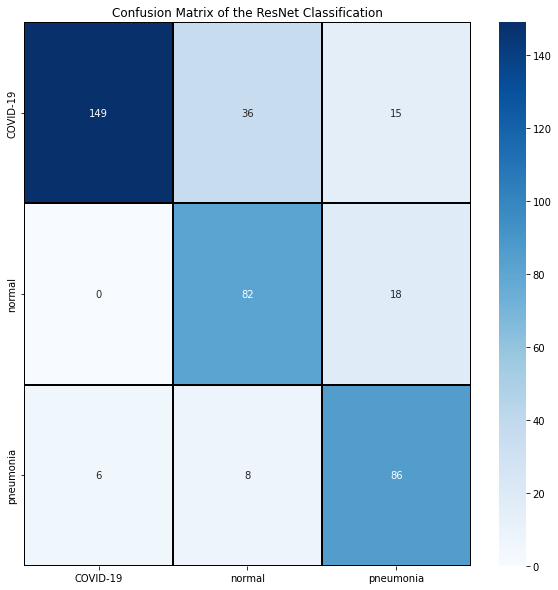

In [ ]:
import seaborn as sns
cm = pd.DataFrame(cm , index = ['0','1','2'] , columns = ['0','1','2'])
labels = ['COVID-19','normal','pneumonia']
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)
plt.title('Confusion Matrix of the ResNet Classification')
plt.show()

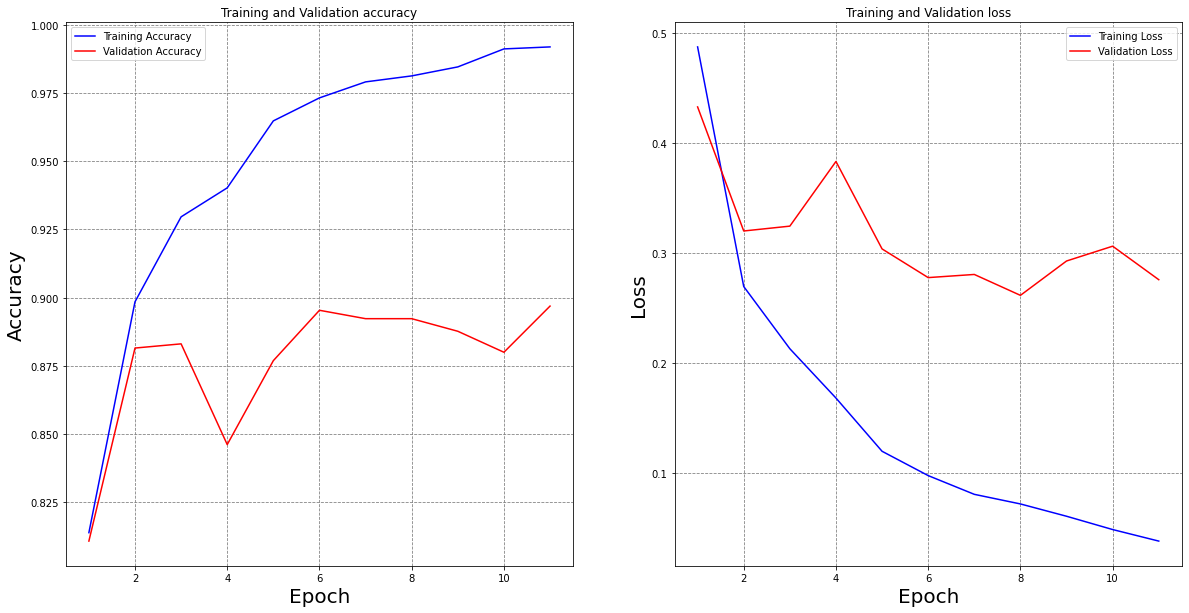

In [ ]:
plotLearningCurve(history,11)